# Data Visualization

##### Create a Passing Network from the 2018 Men's World Cup Final



---

In [1]:
# This builds the soccerutils module in the Analytics Handbook so you can import it
!pip install git+https://github.com/devinpleuler/analytics-handbook.git

In [2]:
from soccerutils.statsbomb import get_events
from soccerutils.pitch import Pitch

In this example, we import `get_events` from the `soccerutils.statsbomb` module, which loads all events from a single game (or competition/season) into a list.

We also import the `Pitch` class from `soccerutils.pitch`, which we can use to plot field lines.

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
wc_final_match_id = 8658
raw_events = get_events(match_id=wc_final_match_id)

`8658` is StatsBomb's match_id for the 2018 World Cup Final

---

In [5]:
lineups = raw_events[0:2]
team_lineup = lineups[1] # Modulate the 1 between [0,1] for [home,away]
team_id = team_lineup['team']['id'] 

The first two entries in a StatsBomb event feed are the home and away lineups.

Generally it's a bad idea to depend on ordering of things in a python dictionary, but we exploit it here since these notebooks are mostly for demonstration purposes.

Here, we've set the `team_lineup` variable to `1`, signifying **Croatia**.

---

In [6]:
starters = {p['player']['id']: {"name": p['player']['name'],
                                "jersey": p['jersey_number']} for p in team_lineup['tactics']['lineup']}

This comprehension creates a dictionary of the team's starters from the lineup event.

---

In [7]:
events = [e for e in raw_events if e['team']['id'] == team_id]
passes = [e for e in raw_events if 'pass' in e.keys()]

In [8]:
matrix = {}
for p in passes:
    if 'outcome' not in p['pass'].keys():
        passer_id = p['player']['id']
        recipient_id = p['pass']['recipient']['id']
        
        a, b = sorted([passer_id, recipient_id]) # <-- Note
        
        if a not in matrix.keys():
            matrix[a] = {}
            
        if b not in matrix[a].keys():
            matrix[a][b] = 0
            
        matrix[a][b] += 1  

Here we generate the passing matrix in the form of a nested dictionary.

The general form we're taking is this: `matrix[player_a][player_b][passes]`

Notice the **Note** where we sort the passer_id and recipient_id. This ensures that totals we accumulate represent both `a -> b`, and `b -> a` passes.

---

In [9]:
positions = {}
for e in events:
    
    if 'player' in e.keys():
        player_id = e['player']['id']
        if player_id not in positions.keys():
            positions[player_id] = {"x":[], "y":[]}
            
        if 'location' in e.keys():
            positions[player_id]['x'].append(e['location'][0])
            positions[player_id]['y'].append(80-e['location'][1])
            
avg_positions = {k:[np.mean(v['x']),np.mean(v['y'])] for k, v in positions.items() if k in starters.keys()}

This block of code generates a dictionary of player event locations, and then uses the dictionary comprehension at the end to extract average positiosn of all the starters.

---

In [10]:
lines = []
weights = []
for k, v in matrix.items():
    if k in starters.keys():
        origin = avg_positions[k]
        for k_, v_ in matrix[k].items():
            if k_ in starters.keys():
                dest = avg_positions[k_]
                lines.append([*origin, *dest])
                weights.append(v_)

We loop through the passing matrix, and build lines (i.e. `[x1,y1,x2,y1]` ) for each passing combination, and store line weights (i.e. the volume of passes exchanged).

---

Below, we build a `Pitch` object, and add various lines and points with `pitch.draw_lines` and `pitch.draw_points`.

You can feed in custom cosmetics of your choosing, as long as their valid `matplotlib.patches` parameters.

We use some logistic functions for `fill_adj` and `weight_adj` so we can better account for potential extreme values in some of the passing connection weights.

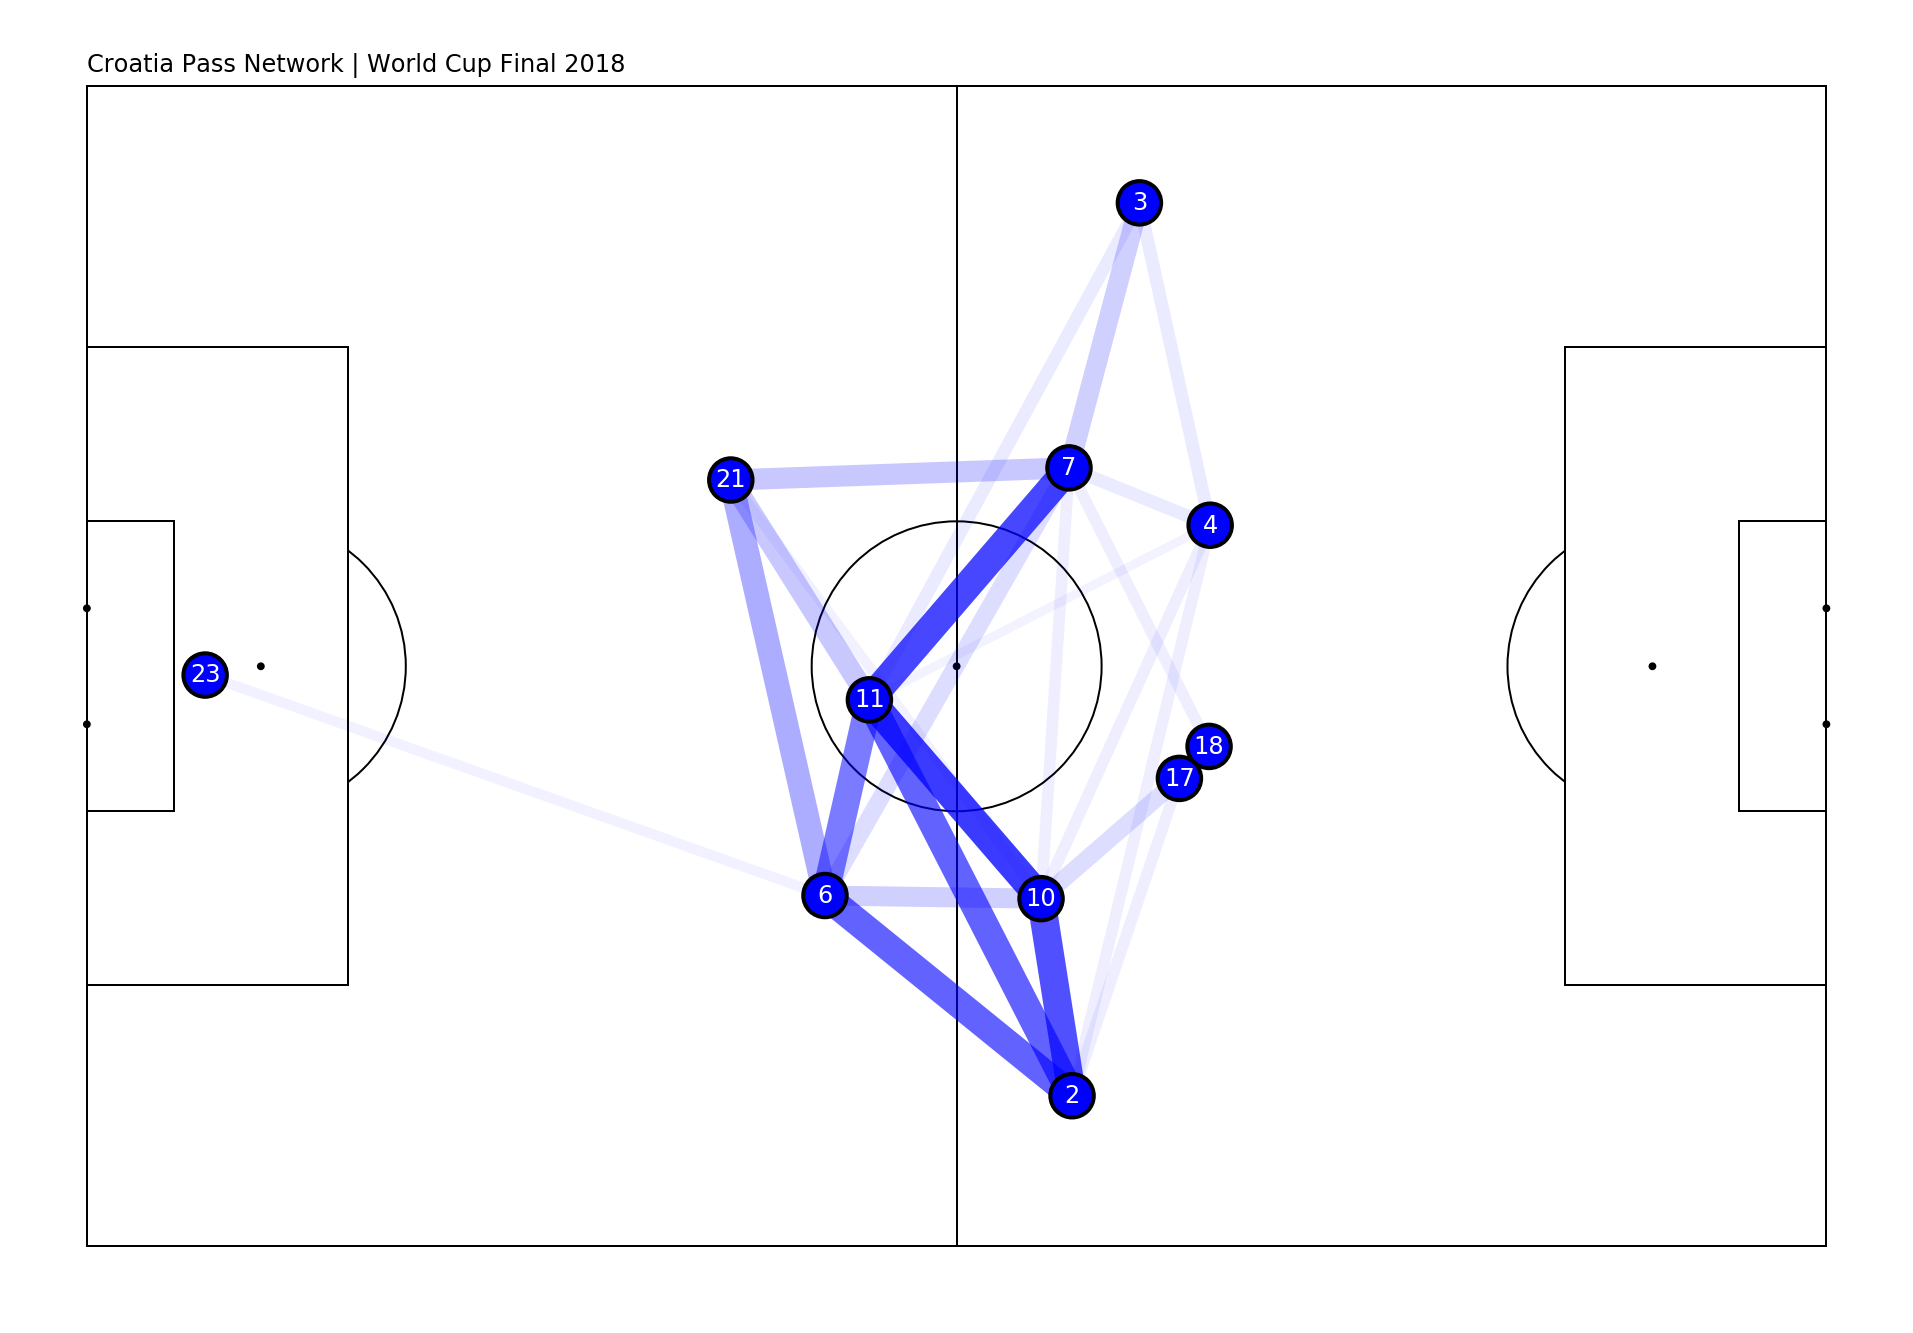

In [11]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_aspect(1)
pitch = Pitch(title="Croatia Pass Network | World Cup Final 2018")
pitch.create_pitch(ax)

fill_adj = lambda x: 0.8 / (1 + np.exp(-(x-20)*0.2))
weight_adj = lambda x: 2 / (1 + np.exp(-(x-10)*0.2))

for i, e in enumerate(lines):
    
    cosmetics = {
        'width': weight_adj(weights[i]),
        'head_width': 0,
        'head_length': 0,
        'facecolor': (0, 0, 1, fill_adj(weights[i])),
        'edgecolor': (0, 0, 0, 0)
    }
    if weights[i] > 5:
        pitch.draw_lines(ax, [e], cosmetics=cosmetics)


cosmetics = {
    'linewidth': 2,
    'facecolor': (0, 0, 1, 1),
    'edgecolor': (0, 0, 0, 1),
    'radius': 1.5
}
pitch.draw_points(ax, [xy for k, xy in avg_positions.items()], cosmetics=cosmetics)

for k, v in avg_positions.items():
    jersey = starters[k]['jersey']
    x,y = v
    
    ax.text(pitch.x_adj(x), pitch.y_adj(y),
            jersey, fontsize=12,
            ha='center', va='center',
            color='white')


plt.ylim(pitch.ylim)
plt.xlim(pitch.xlim)
plt.axis('off')
plt.show()

---

Devin Pleuler 2020